In [1]:
# Set project root to ChessClassification

import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Project root added to path: {project_root}")

Project root added to path: /home/zmoraj/ChessClassification


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from src.network.evaluation import evaluate
from src.network.training import train
from src.preprocessing.dataset import ChessSquareDataset, ChessBoardDataset
from src.utils.dataset_utils import get_dataset_stats, build_transforms
from src.utils.plotting import visualize_test_samples, plot_training_history
from tqdm import tqdm
import numpy as np

In [3]:
# Setup 

TRAIN_DATA_ROOT = os.path.join(project_root, "data/train/synthetic")
VAL_DATA_ROOT = os.path.join(project_root, "data/validation/synthetic")
TEST_SYNTHETIC_DATA_ROOT = os.path.join(project_root, "data/test/synthetic") 
TEST_REAL_DATA_ROOT = os.path.join(project_root, "data/test/real")
BATCH_SIZE = 2
NUM_WORKERS = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

temp_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

# Load Raw Dataset
train_dataset = ChessBoardDataset(root_dir=TRAIN_DATA_ROOT, transform=temp_transform)
val_dataset = ChessBoardDataset(root_dir=VAL_DATA_ROOT, transform=temp_transform)

print(f"Training samples: {len(train_dataset)} | Validation samples: {len(val_dataset)}")

# Compute Statistics (Train Set Only)
train_mean, train_std = get_dataset_stats(train_dataset, batch_size=256, num_workers=NUM_WORKERS)
print(f"\nCalculated Training Mean: {train_mean}")
print(f"Calculated Training Std:  {train_std}")

# Build Final datasets and DataLoaders
baseline_config = {} 
final_transform = build_transforms(train_mean, train_std, config=baseline_config)

train_dataset = ChessBoardDataset(root_dir=TRAIN_DATA_ROOT, transform=final_transform)
val_dataset = ChessBoardDataset(root_dir=VAL_DATA_ROOT, transform=final_transform)
test_synthetic_dataset = ChessBoardDataset(root_dir=TEST_SYNTHETIC_DATA_ROOT, transform=final_transform)
test_real_dataset = ChessBoardDataset(root_dir=TEST_REAL_DATA_ROOT, transform=final_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_synthetic_loader = DataLoader(test_synthetic_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_real_loader = DataLoader(test_real_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

device: cuda
Training samples: 1125 | Validation samples: 243
Computing mean and std for training data...


Calculating Stats: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


Calculated Training Mean: [0.5405116677284241, 0.5397956371307373, 0.5381444692611694]
Calculated Training Std:  [0.10387232899665833, 0.10447882860898972, 0.10541636496782303]


In [4]:
# Define baseline model

def get_baseline_model(num_classes=13):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Replace final FC layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model

In [5]:
# Initialize

model = get_baseline_model().to(device)

print("\nModel Initialized: ResNet18 (Pretrained)")
print(f"Output classes: {model.fc.out_features}")


Model Initialized: ResNet18 (Pretrained)
Output classes: 13


Training on cuda for 15 epochs...


Training Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 | Train: Loss=0.0900 Acc=0.9780  Val: Loss=0.0021 Acc=1.0000   [Saved Best]
Epoch 2/15 | Train: Loss=0.0011 Acc=1.0000  Val: Loss=0.0010 Acc=1.0000  
Epoch 3/15 | Train: Loss=0.0005 Acc=1.0000  Val: Loss=0.0006 Acc=1.0000  
Epoch 4/15 | Train: Loss=0.0003 Acc=1.0000  Val: Loss=0.0004 Acc=1.0000  
Epoch 5/15 | Train: Loss=0.0002 Acc=1.0000  Val: Loss=0.0003 Acc=1.0000  
Epoch 6/15 | Train: Loss=0.0001 Acc=1.0000  Val: Loss=0.0003 Acc=1.0000  
Epoch 7/15 | Train: Loss=0.0001 Acc=1.0000  Val: Loss=0.0002 Acc=1.0000  
Epoch 8/15 | Train: Loss=0.0001 Acc=1.0000  Val: Loss=0.0002 Acc=1.0000  
Epoch 9/15 | Train: Loss=0.0000 Acc=1.0000  Val: Loss=0.0002 Acc=1.0000  
Epoch 10/15 | Train: Loss=0.0000 Acc=1.0000  Val: Loss=0.0002 Acc=1.0000  
Epoch 11/15 | Train: Loss=0.0000 Acc=1.0000  Val: Loss=0.0001 Acc=1.0000  
Epoch 12/15 | Train: Loss=0.0000 Acc=1.0000  Val: Loss=0.0001 Acc=1.0000  
Epoch 13/15 | Train: Loss=0.0000 Acc=1.0000  Val: Loss=0.0001 Acc=1.0000  
Epoch 14/15 | Train: 

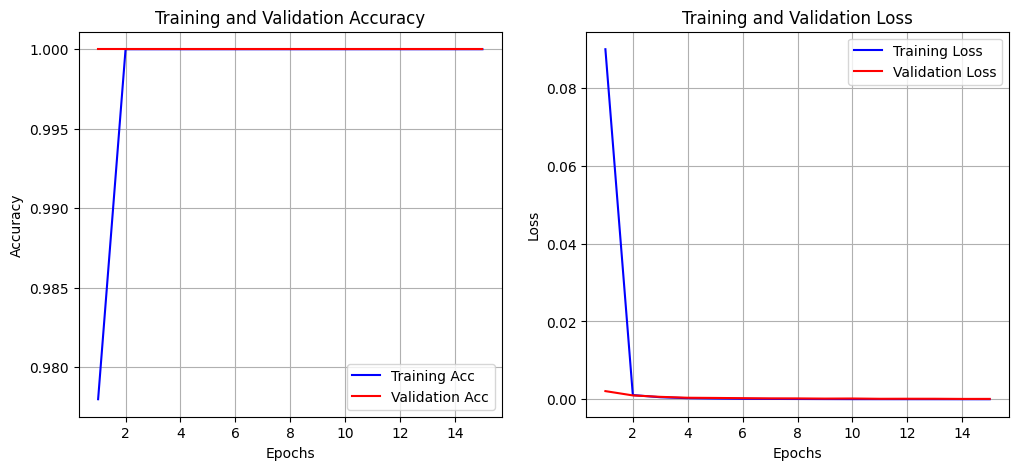

In [6]:
# Training loop

# Configuration
lr = 1e-4
num_epochs = 15
class_weights = torch.ones(13) 
class_weights[12] = 0.1 
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training
best_model, history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=None,
    num_epochs=num_epochs,
    device=device,
    save_path='baseline_resnet18.pth'
)

# Plotting train and validation statistics
plot_training_history(history)

In [7]:
# Evaluation on synthetic test data

square_acc, board_acc = evaluate(best_model, test_synthetic_loader, device)

print(f"Square accuracy: {square_acc:.2f}")
print(f"Board accuracy: {board_acc:.2f}")

Starting Evaluation on 384 boards...


Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

Square accuracy: 99.87
Board accuracy: 91.93


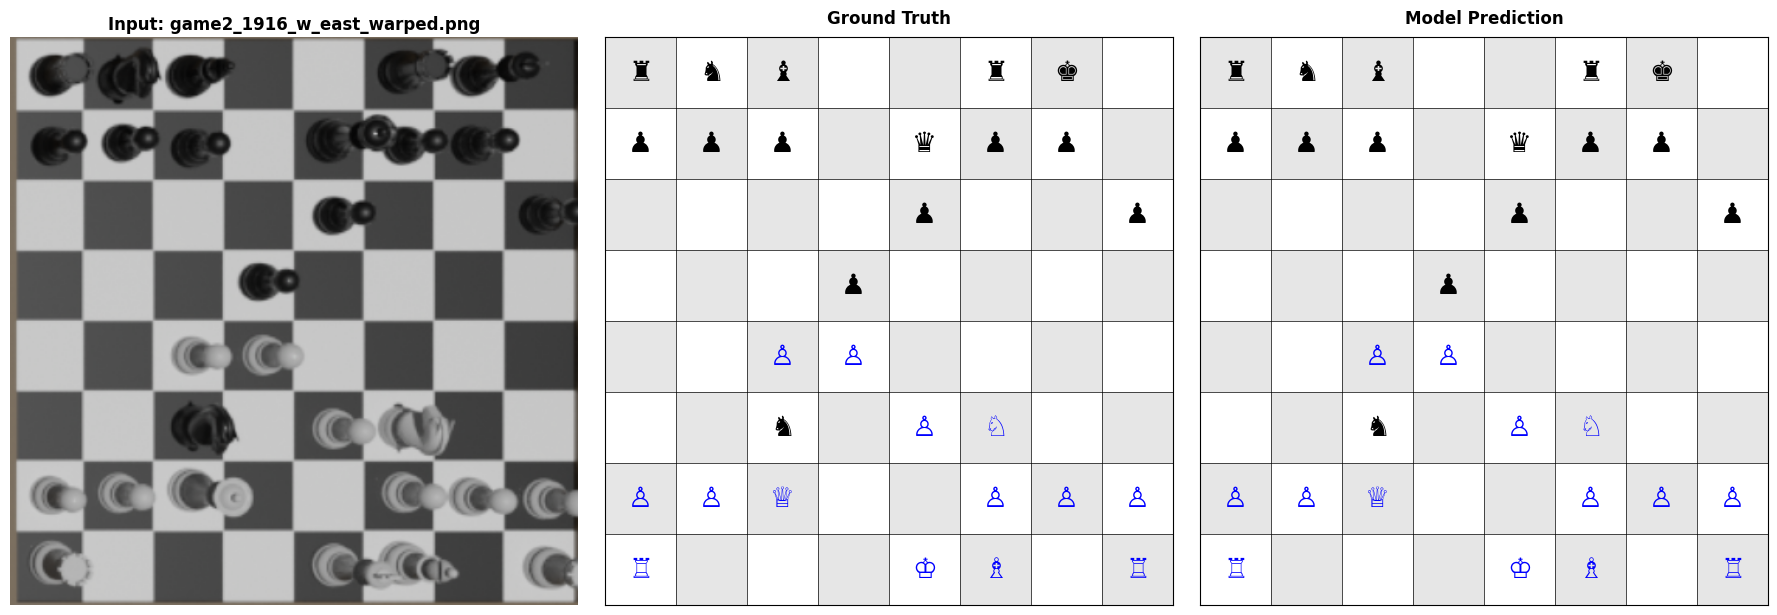

True FEN: rnb2rk1/ppp1qpp1/4p2p/3p4/2PP4/2n1PN2/PPQ2PPP/R3KB1R
Pred FEN: rnb2rk1/ppp1qpp1/4p2p/3p4/2PP4/2n1PN2/PPQ2PPP/R3KB1R
PERFECT MATCH


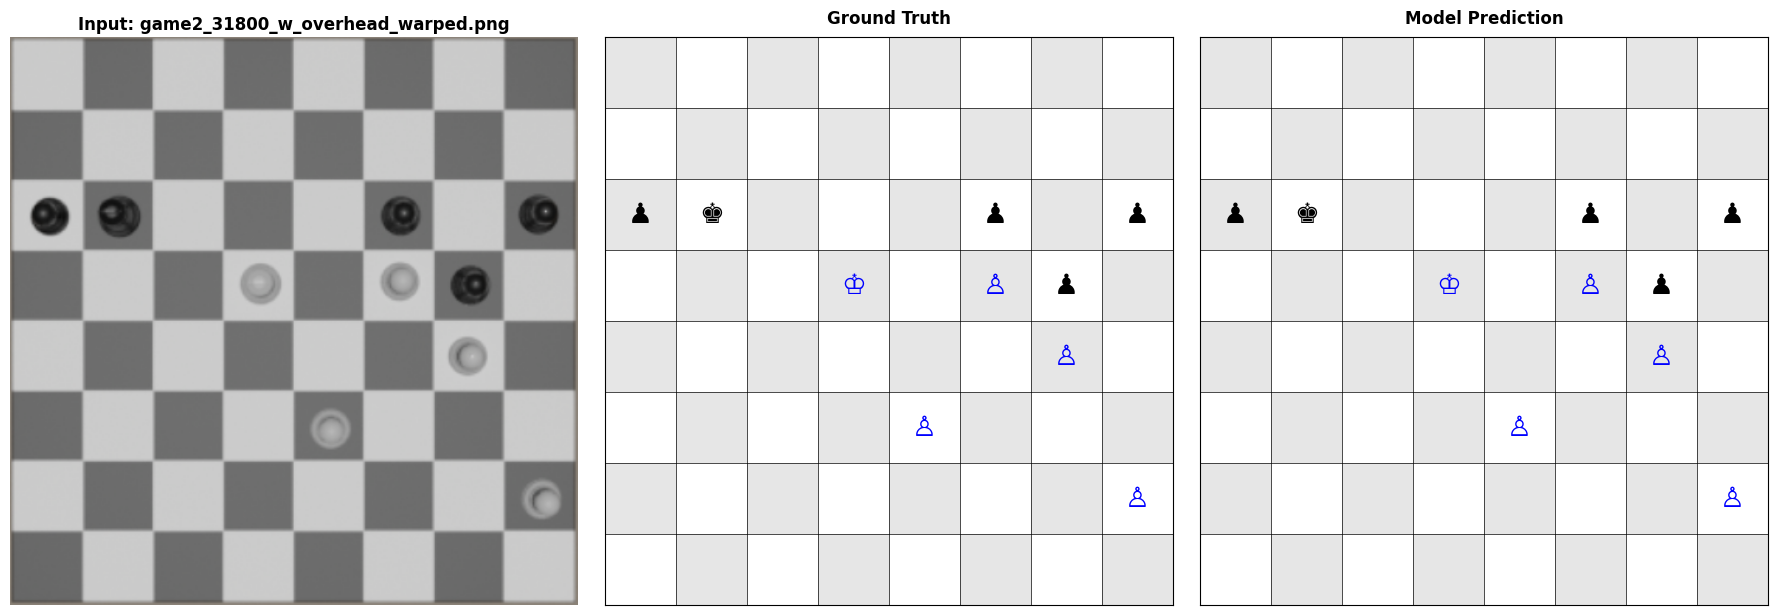

True FEN: 8/8/pk3p1p/3K1Pp1/6P1/4P3/7P/8
Pred FEN: 8/8/pk3p1p/3K1Pp1/6P1/4P3/7P/8
PERFECT MATCH


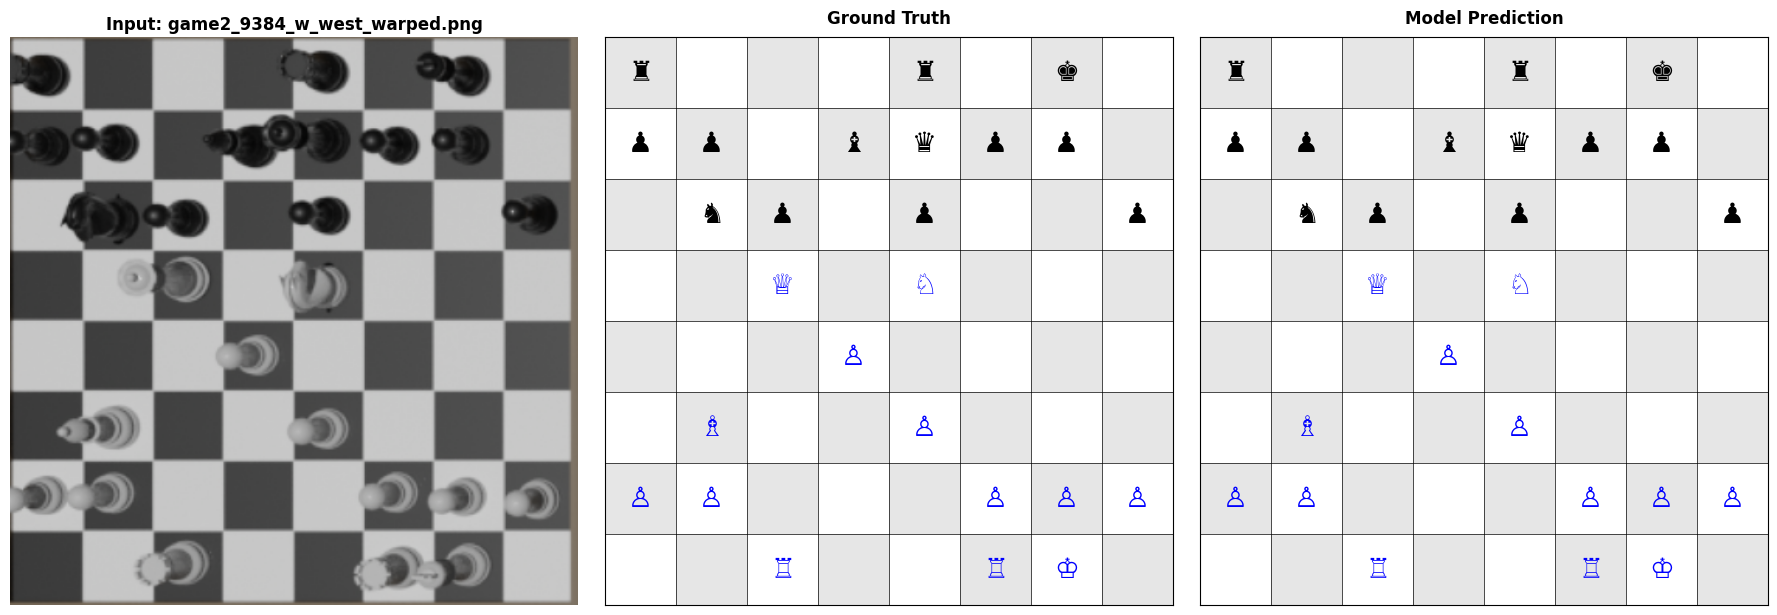

True FEN: r3r1k1/pp1bqpp1/1np1p2p/2Q1N3/3P4/1B2P3/PP3PPP/2R2RK1
Pred FEN: r3r1k1/pp1bqpp1/1np1p2p/2Q1N3/3P4/1B2P3/PP3PPP/2R2RK1
PERFECT MATCH


In [8]:
# Visualizing model outputs

test_synthetic_dataset.return_fen = True
visualize_test_samples(model, test_synthetic_dataset, num_samples=3, device=device)

In [9]:
# Evaluation on real test data

square_acc, board_acc = evaluate(best_model, test_real_loader, device)

print(f"Square accuracy: {square_acc:.2f}")
print(f"Board accuracy: {board_acc:.2f}")

Starting Evaluation on 132 boards...


Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

Square accuracy: 61.83
Board accuracy: 0.00


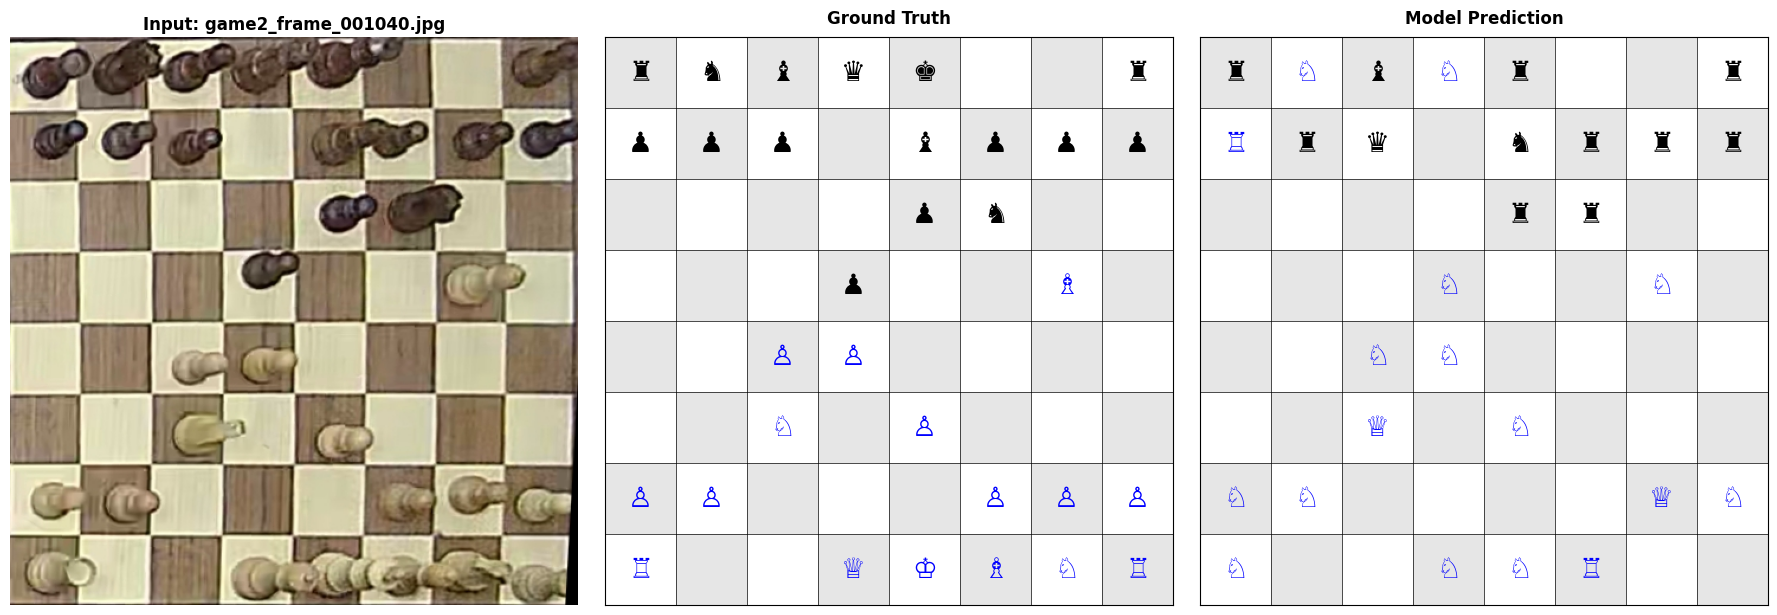

True FEN: rnbqk2r/ppp1bppp/4pn2/3p2B1/2PP4/2N1P3/PP3PPP/R2QKBNR
Pred FEN: rNbNr2r/Rrq1nrrr/4rr2/3N2N1/2NN4/2Q1N3/NN4QN/N2NNR2
MISMATCH



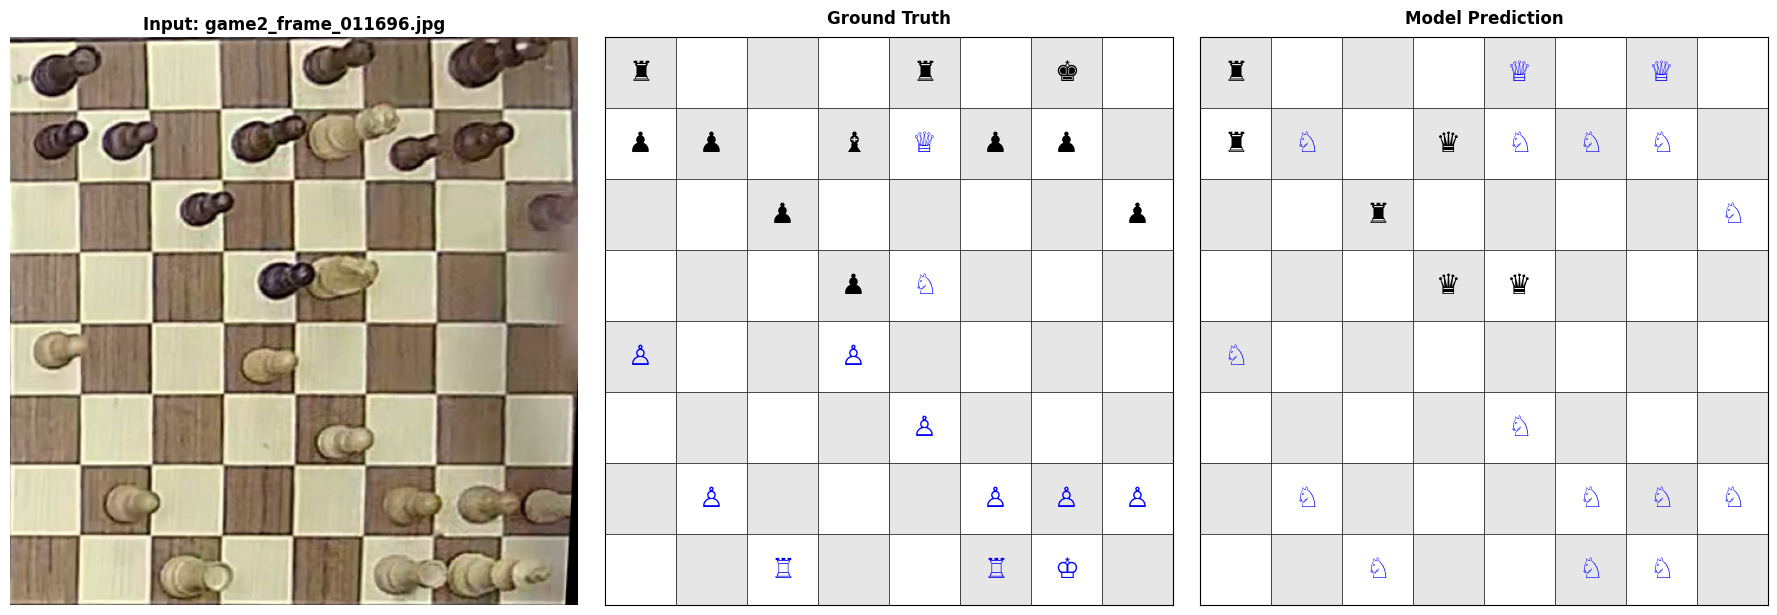

True FEN: r3r1k1/pp1bQpp1/2p4p/3pN3/P2P4/4P3/1P3PPP/2R2RK1
Pred FEN: r3Q1Q1/rN1qNNN1/2r4N/3qq3/N7/4N3/1N3NNN/2N2NN1
MISMATCH



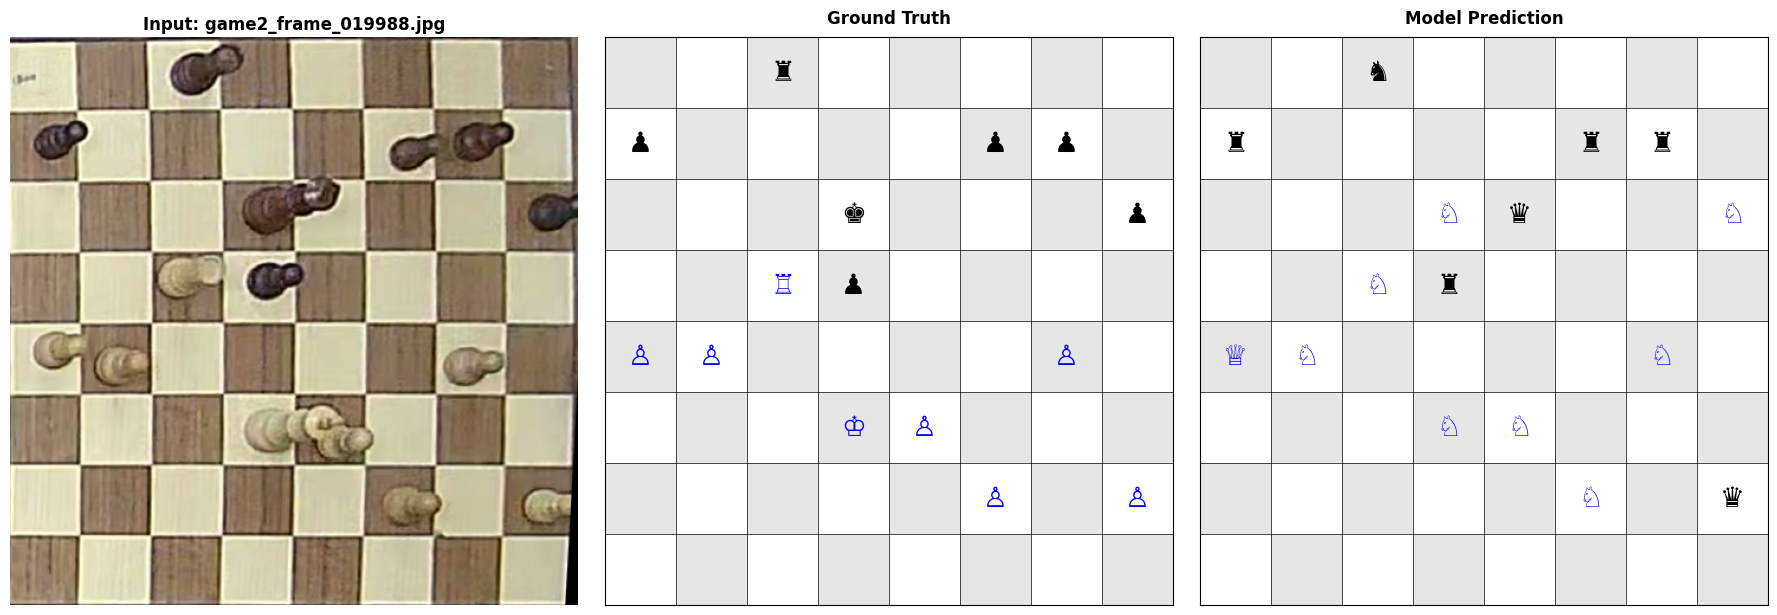

True FEN: 2r5/p4pp1/3k3p/2Rp4/PP4P1/3KP3/5P1P/8
Pred FEN: 2n5/r4rr1/3Nq2N/2Nr4/QN4N1/3NN3/5N1q/8
MISMATCH



In [12]:
# Visualizing model outputs

test_real_dataset.return_fen = True
visualize_test_samples(model, test_real_dataset, num_samples=3, device=device)